In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier

import tensorflow as tf
from keras.layers import Input, Conv1D, Flatten, Dense, Dropout,Bidirectional,LSTM,BatchNormalization,MaxPooling1D
from keras.models import Model
from keras.regularizers import L1
from keras.callbacks import EarlyStopping

# High Fidelity PEM model

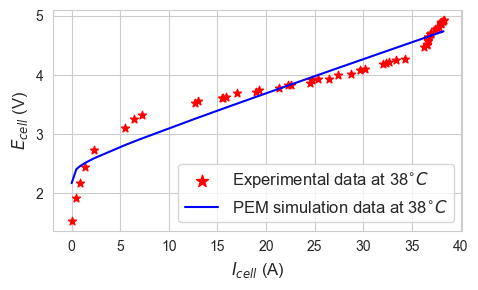

In [2]:
pem_df = pd.read_csv("HighFidelityPEM.csv")

sns.set_style("whitegrid")
# Plot the line plot
fig, ax = plt.subplots(figsize=(5,3))
ax.scatter(pem_df['current'],pem_df['actual_Vcell'],marker='*',c='r', label='Experimental data at 38$^{\circ} C$')
ax.plot(pem_df['current'],pem_df['predicted_Vcell'],c='b', label='PEM simulation data at 38$^{\circ} C$')
ax.set_xlabel('$I_{cell}$ (A)',fontsize=12)
ax.set_ylabel('$E_{cell}$ (V)',fontsize=12)
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
ax.legend(markerscale=1.5,loc='lower right',fontsize=12)
# ax.set_ylim([0.4,1.01])

plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/PEM_simulation_model_prediced_actual.pdf', dpi=300)

# Display the plot
plt.show()

# Helper functions

In [3]:
def sliding_window(data, window_size, stride):
    # Define the window size and stride
    
    # Initialize variables to store the segments and labels
    
    residuals = []
    labels = []
    C = []
    
    # Iterate over each class label in the data
    for label in data['Fault_class'].unique():
        # Get the data for the current class label
        class_data = data[data['Fault_class'] == label].iloc[2*window_size:]
    
        # Iterate over the data
        for i in range(0, len(class_data) - window_size, stride):
            # Get the current segment and label
            
            residual = class_data.iloc[i:i+window_size,1:7]
            
            label = class_data.iloc[i+window_size][-1]

            c = class_data.iloc[i+window_size,7:-1]
        
            # Add the segment and label to the list
            residuals.append(residual)
            labels.append(label)
            C.append(c)
    
    R,Y,psuedo_label= np.array(residuals),  np.array(labels), np.array(C)

    
    # Return the segments and labels
    return R,Y,psuedo_label

def DeepLearningModel(InputFeature,Target,last_layer_activn,loss_fn):
# Define input layer
    input_layer = Input(shape=(InputFeature.shape[1],x_train.shape[2]))
    # Define LSTM layers with batch normalization in between
    cnn1 = Conv1D(32,3,padding='same', activation='relu')(input_layer)
    cnn1 = Conv1D(32,3,padding='same', activation='relu')(cnn1)
    cnn1 = Flatten()(cnn1)
    # Define hidden layer with batch normalization
    hidden_layer = Dense(units=64, activation='relu')(cnn1)
    # Define output layer with sigmoid activation function for binary classification
    outputs = Dense(Target.shape[1], activation=last_layer_activn)(hidden_layer)
    # Define the model
    nn_model = Model(inputs=input_layer, outputs=outputs)
    # Compile the model with binary cross-entropy loss function and Adam optimizer
    nn_model.compile(loss=loss_fn, optimizer='adam', metrics=['binary_accuracy'])
    return nn_model

def resample(X_sc, Y, Z, num_samples):
    from sklearn.utils import resample

    # Check if the input data is 2D or 3D
    if len(X_sc.shape) == 3:
        num_features = X_sc.shape[1]
        num_time_steps = X_sc.shape[2]
        x_sample = np.zeros((num_samples * np.unique(Y).size, num_features, num_time_steps))
    else:
        num_features = X_sc.shape[1]
        x_sample = np.zeros((num_samples * np.unique(Y).size, num_features))
    y_sample = np.zeros(num_samples * np.unique(Y).size)
    z_sample = np.zeros((num_samples * np.unique(Y).size, Z.shape[1]))  # Assuming Z has the same number of features as X

    for i, label in enumerate(np.unique(Y)):
        class_indices = np.where(Y == label)[0]
        sampled_indices = resample(class_indices, n_samples=num_samples, replace=False, random_state=0)
        x_sample[i*num_samples:(i+1)*num_samples] = X_sc[sampled_indices]
        y_sample[i*num_samples:(i+1)*num_samples] = Y[sampled_indices]
        z_sample[i*num_samples:(i+1)*num_samples] = Z[sampled_indices]

    return x_sample, y_sample, z_sample

def FineTunedModel(nn_model,x_train,y_train,X_sc,Y_ohe):

    from keras.layers import BatchNormalization
    from keras.models import clone_and_build_model

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model_copy= clone_and_build_model(nn_model)
    model_copy.set_weights(weights=nn_model.get_weights())

    intermediate_model = Model(inputs=model_copy.input,outputs=model_copy.layers[-2].output)

    for l in intermediate_model.layers:
        l.trainable=False

    fine_tuned_layers = Dense(units=64,activation='relu')(intermediate_model.output)
    output_layer = Dense(units=Y_ohe.shape[1],activation='softmax')(fine_tuned_layers)

    # Define the model
    fine_tuned_model = Model(inputs=intermediate_model.input, outputs=output_layer)

    # Compile the model with binary cross-entropy loss function and Adam optimizer
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #categorical_hinge

    #train the model with freezed layer
    history1=fine_tuned_model.fit(x_train, y_train, epochs=500, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), callbacks=[early_stop], verbose=0)

    for l in fine_tuned_model.layers:
        l.trainable=True

    # Create a custom Adam optimizer with a small learning rate
    custom_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)

    # Compiling again is necessary to update the trainable parameter before training
    fine_tuned_model.compile(loss='categorical_crossentropy', optimizer=custom_optimizer, metrics=['accuracy']) #categorical_hinge

    #train the model with unfreezed layer
    history2=fine_tuned_model.fit(x_train, y_train, epochs=50, batch_size=int(len(x_train) * 0.2), validation_data=(X_sc[::50], Y_ohe[::50]), verbose=0)

    return fine_tuned_model,history1,history2

# The plot for ARRs

In [4]:
def rms_value(x,window_size=10):
    return x.rolling(window=window_size).apply(lambda x: np.sqrt(np.mean(x**2)) if not x.isna().any() else np.nan)

## Normal condition

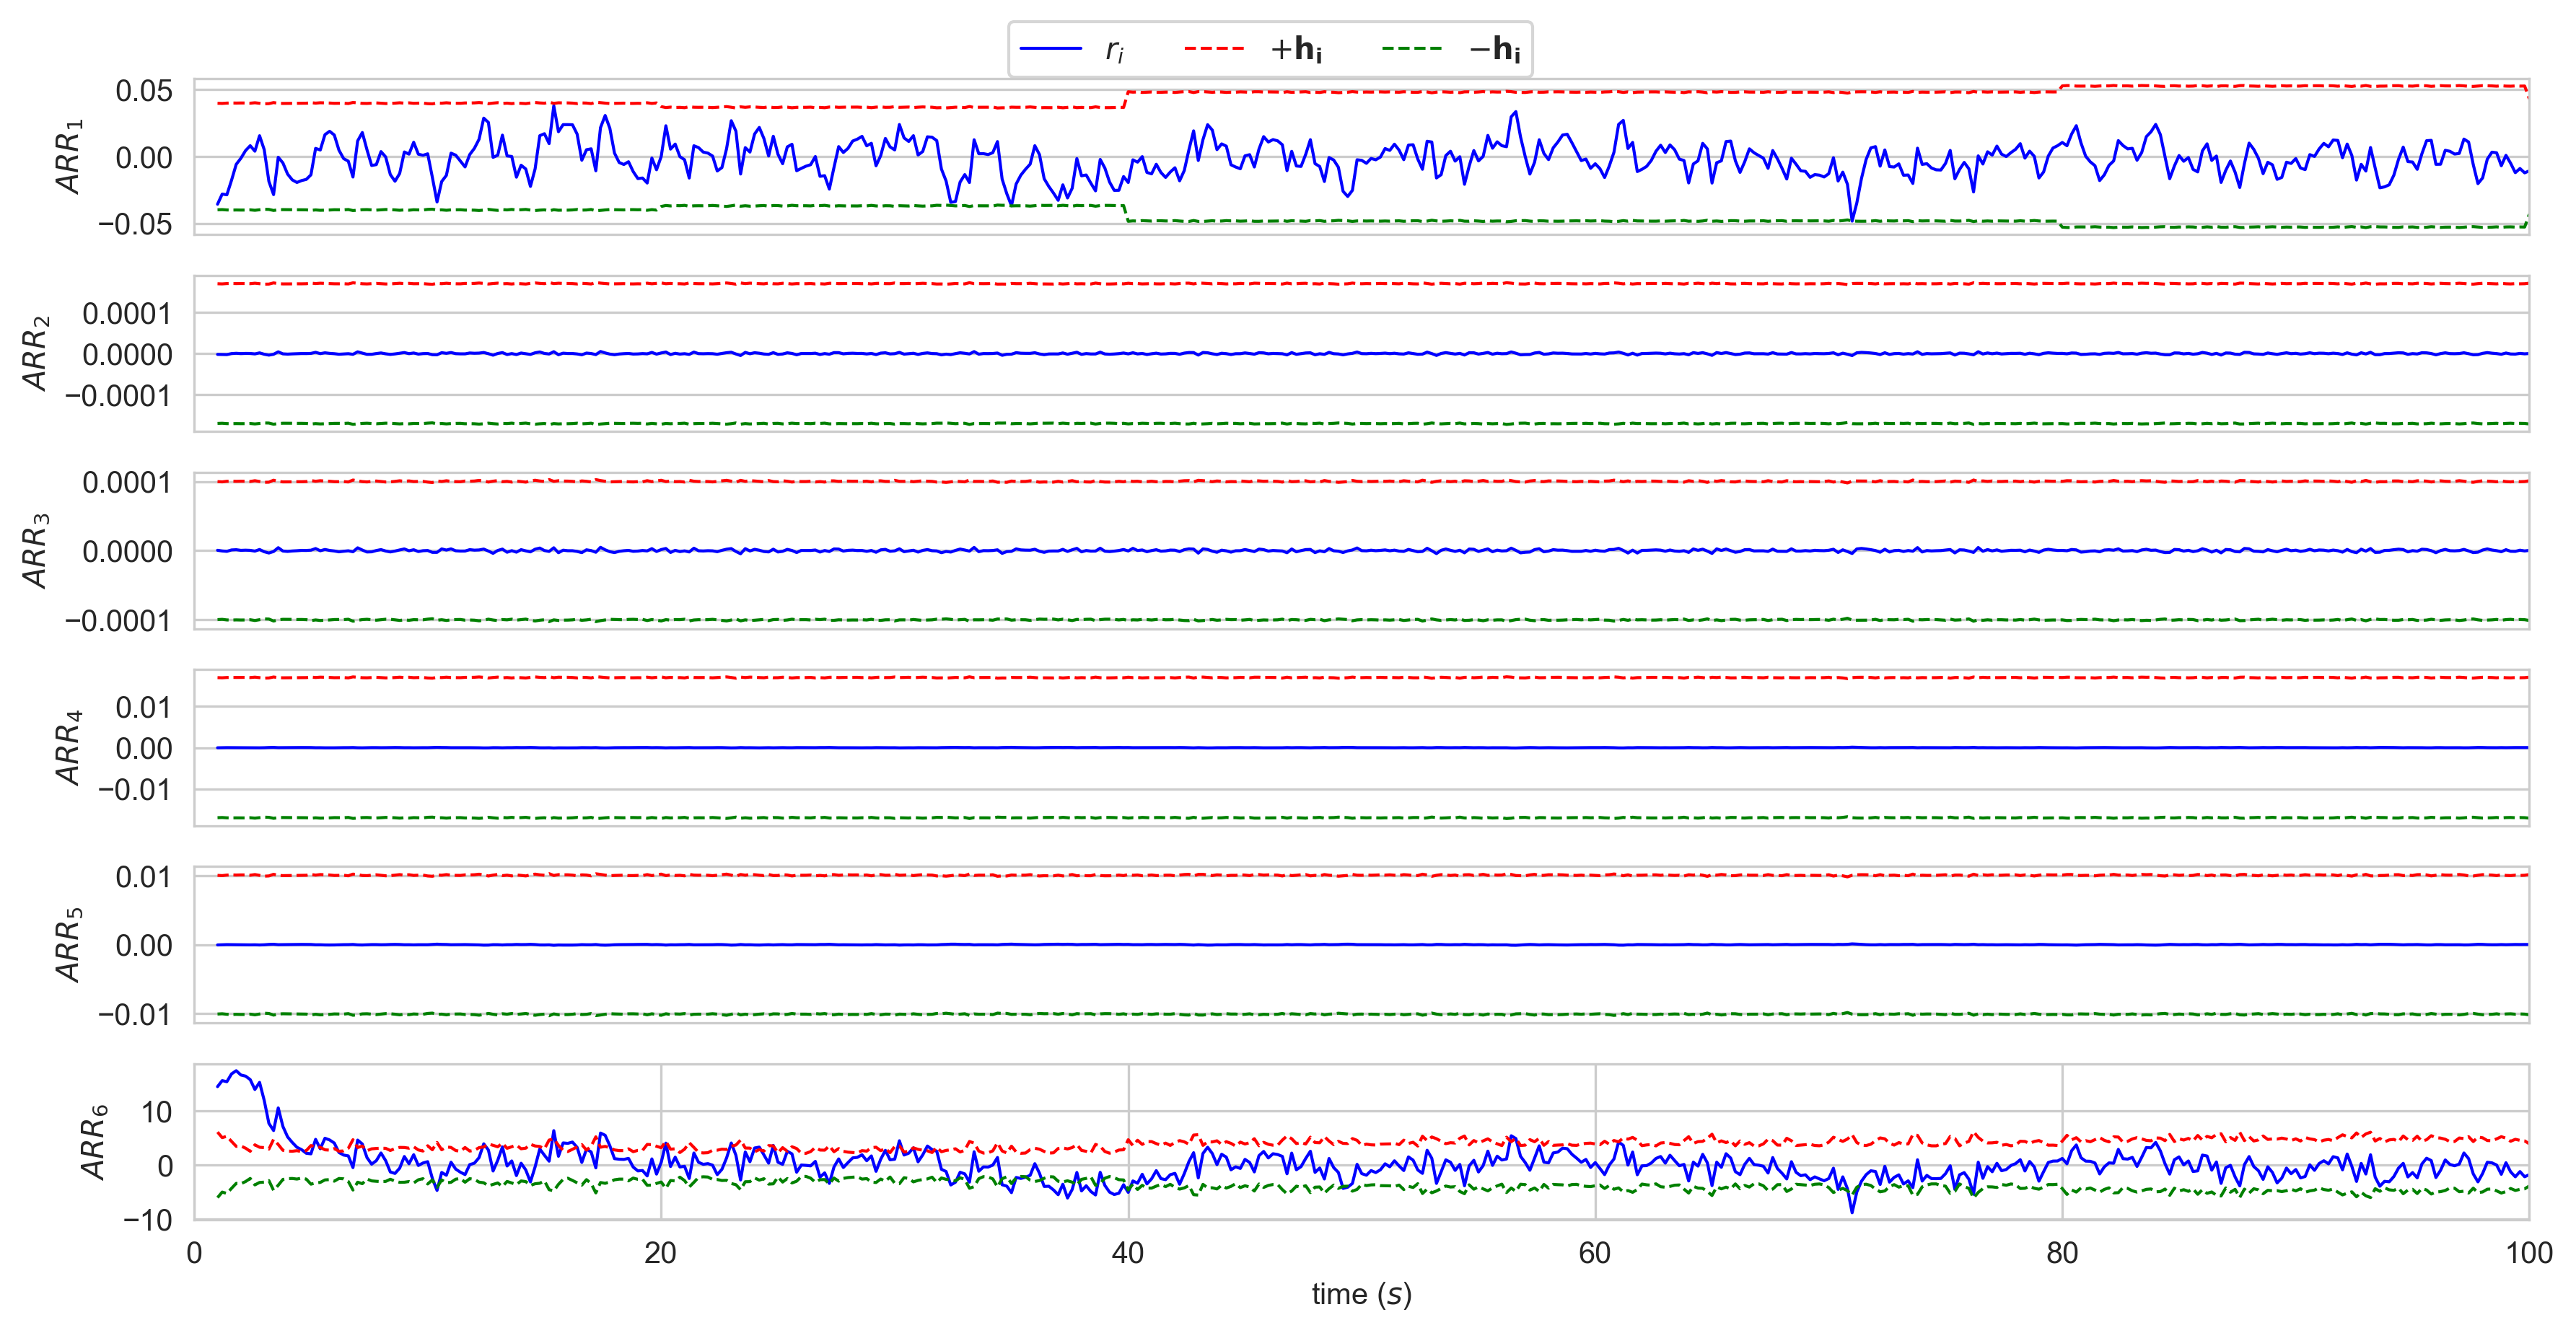

In [5]:
import matplotlib.pyplot as plt
import numpy as np


arr_df = pd.read_csv('ARR_threshold.csv')
normal_df = arr_df[(arr_df['time'] >= 1) & (arr_df['time'] <= 100)]


sns.set_style("whitegrid")

# Define the array of plots
fig, axs = plt.subplots(6, 1, figsize=(12, 6),dpi=300)

# Loop over the plots and plot the data
for i, ax in enumerate(axs.flat):
    ax.plot(normal_df .time, normal_df [f"ARR{i+1}"], label='$r_{i}$', color='b', linewidth=1)
    ax.plot(normal_df .time, normal_df [f"h{i+1}"], label='$+ \mathbf{h_{i}}$', color='red', linewidth=1,linestyle='--',alpha=1)
    ax.plot(normal_df .time, normal_df [f"h{i+1}"] * -1, label='$- \mathbf{h_{i}}$', color='green', linewidth=1,linestyle='--',alpha=1)
    # if i+1 == 3:
        # ax.set_ylim([-0.0008,0.0008])

    # elif i+1 ==6:
        # ax.set_ylim([-90,90])

    ax.set_xlim([0,100])

    if i + 1 < 6:
        ax.set_xticks([])  # Hide x-ticks for all subplots except the last one
        


    # ax.set_ylim([arr_df[f"ARR{i+1}"].min(), arr_df[f"ARR{i+1}"].max()])
    ax.set_ylabel(f'$ARR_{i+1}$')#ax.set_title(f'$ARR_{i+1}$')
ax.set_xlabel('time ($s$)')
# Add horizontal spacing between subplots
# plt.subplots_adjust(hspace=1)
# plt.subplots_adjust(wspace=0.4)
# Add a common legend
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.6, 1.03), ncol=3,markerscale=1.5,fontsize=10)
plt.tight_layout()

# Increase DPI and save the figure
fig.savefig('Plots/normal_condition_arr_plot.pdf', dpi=300,bbox_inches='tight')
# Display the plots
plt.show()

## Fault condition-𝑅𝑑𝑖𝑓 𝑓 ,𝑂2 Increase in crossover diffusion [0 1 1 0 0 0]

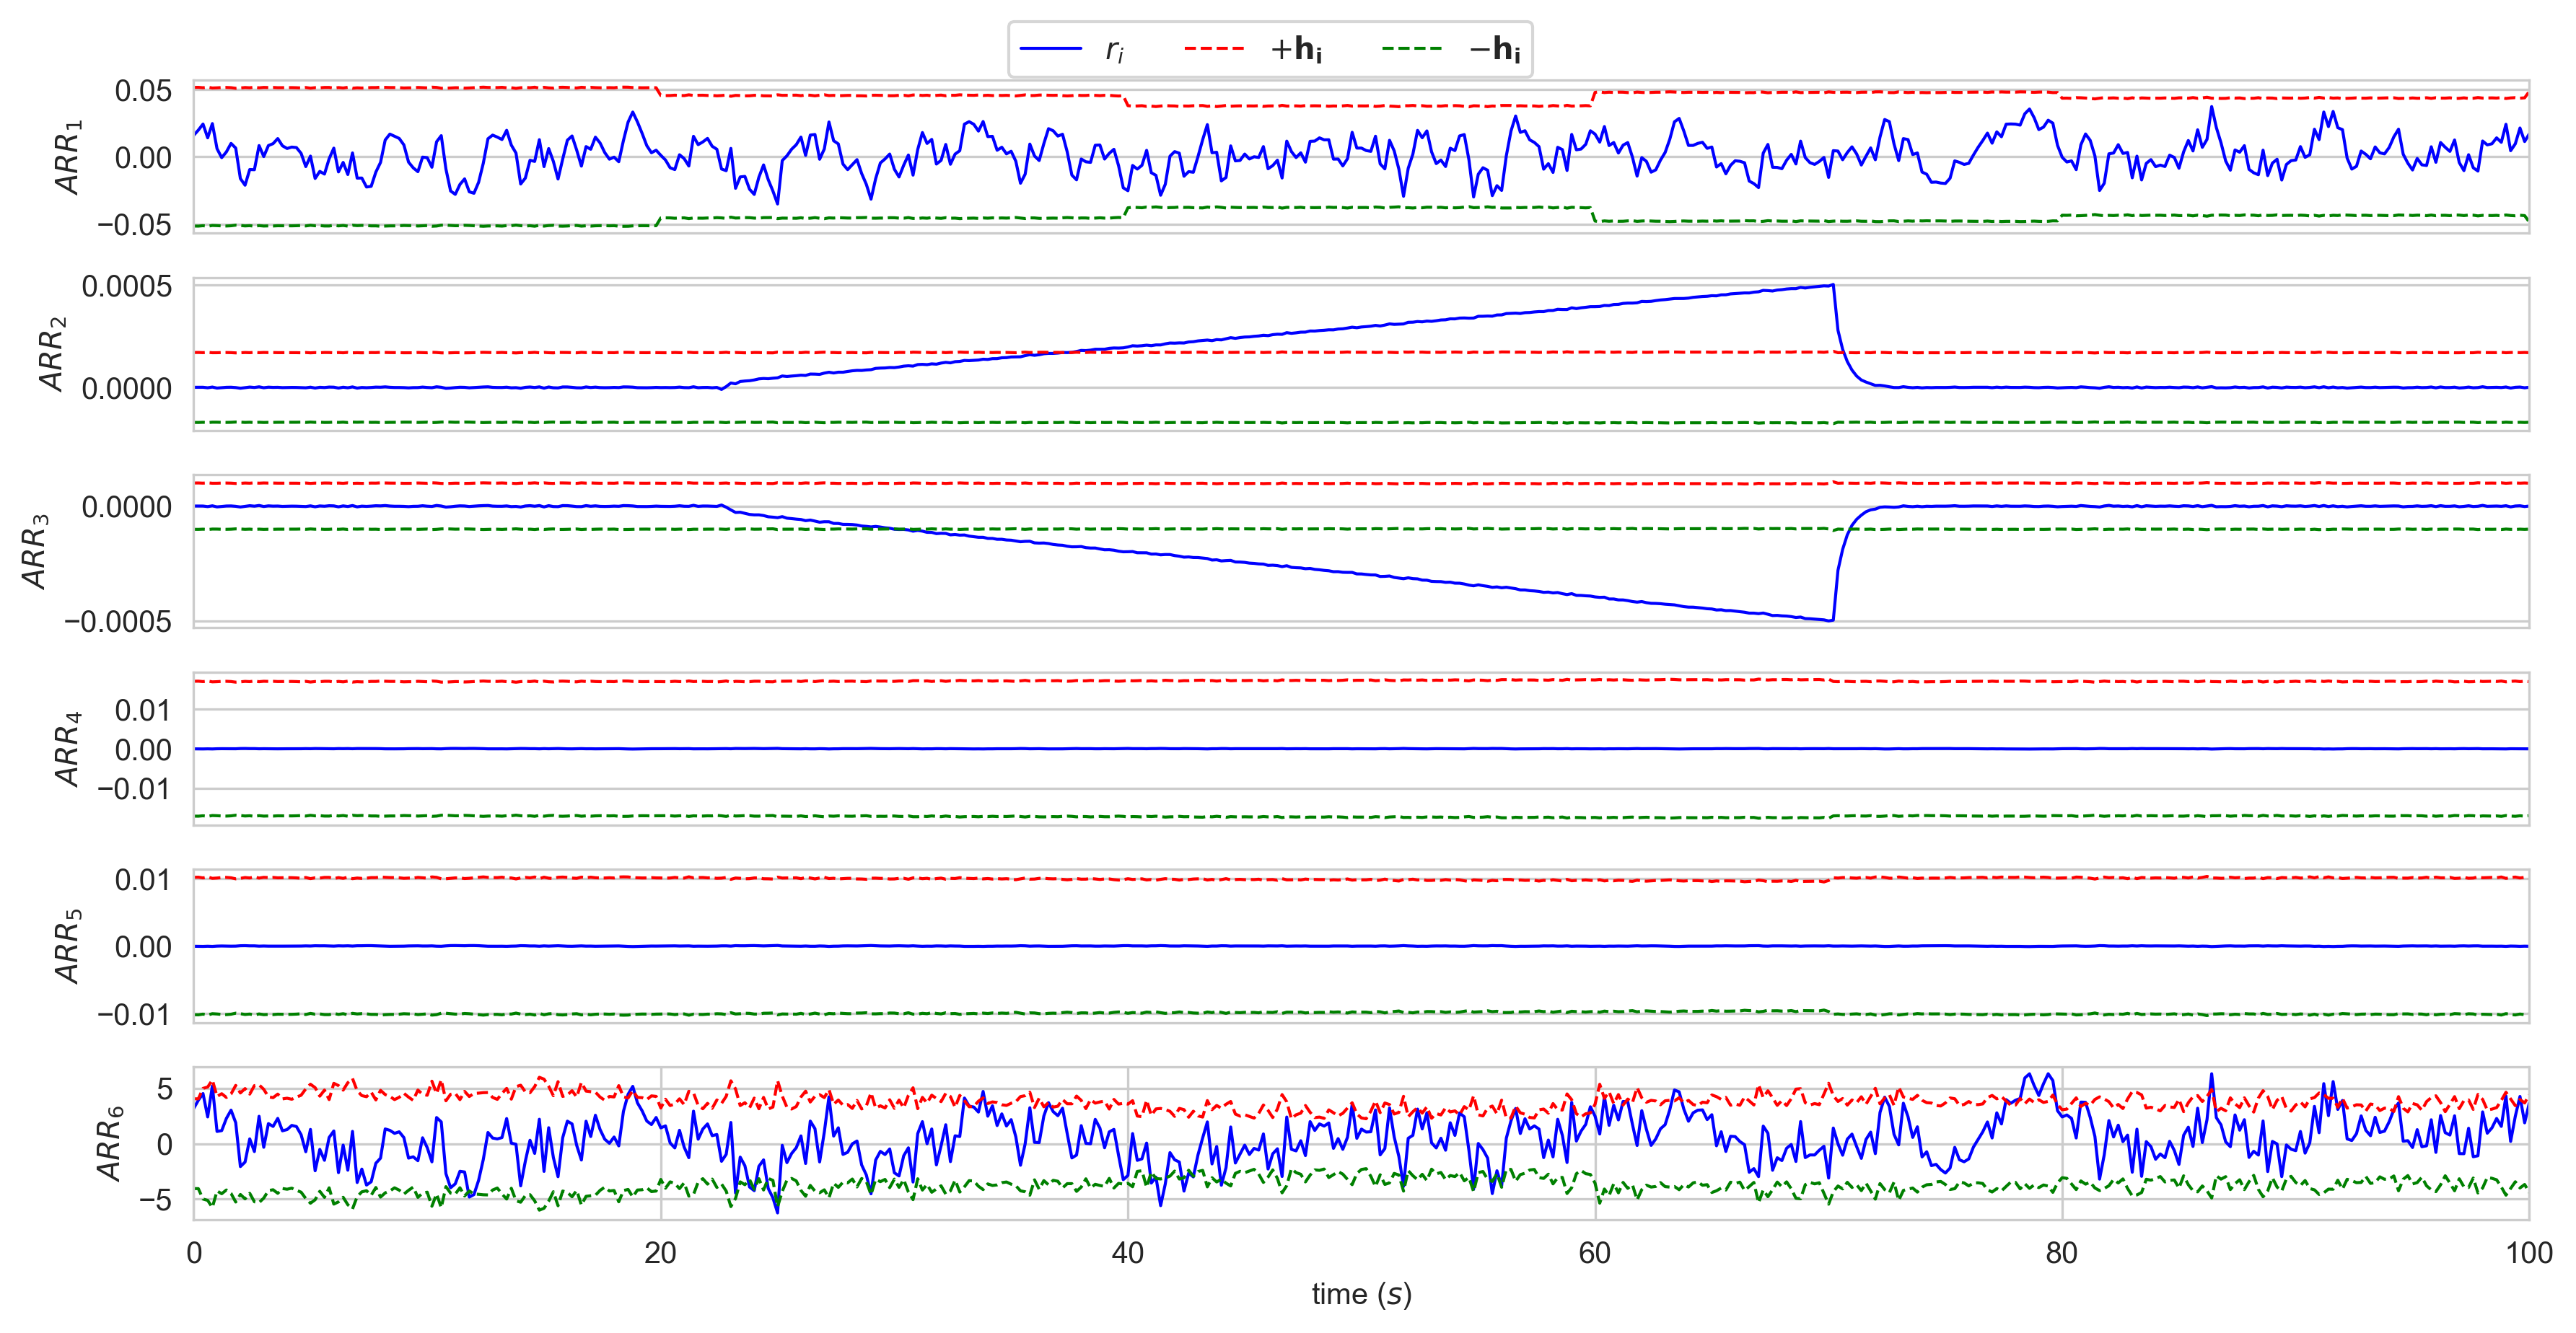

In [6]:
import matplotlib.pyplot as plt
import numpy as np


arr_df = pd.read_csv('ARR_threshold.csv')
Rdiff_fault_df = arr_df[(arr_df['time'] >= 380) & (arr_df['time'] <= 480)]

time_axis = np.linspace(0,100,len(Rdiff_fault_df))


sns.set_style("whitegrid")

# Define the array of plots
fig, axs = plt.subplots(6, 1, figsize=(12, 6),dpi=300)

# Loop over the plots and plot the data
for i, ax in enumerate(axs.flat):
    ax.plot(time_axis, Rdiff_fault_df  [f"ARR{i+1}"], label='$r_{i}$', color='b', linewidth=1)
    ax.plot(time_axis, Rdiff_fault_df  [f"h{i+1}"], label='$+ \mathbf{h_{i}}$', color='red', linewidth=1,linestyle='--',alpha=1)
    ax.plot(time_axis, Rdiff_fault_df  [f"h{i+1}"] * -1, label='$- \mathbf{h_{i}}$', color='green', linewidth=1,linestyle='--',alpha=1)
    # if i+1 == 3:
        # ax.set_ylim([-0.0008,0.0008])

    # elif i+1 ==6:
        # ax.set_ylim([-90,90])

    ax.set_xlim([0,100])

    if i + 1 < 6:
        ax.set_xticks([])  # Hide x-ticks for all subplots except the last one
        


    # ax.set_ylim([arr_df[f"ARR{i+1}"].min(), arr_df[f"ARR{i+1}"].max()])
    ax.set_ylabel(f'$ARR_{i+1}$')#ax.set_title(f'$ARR_{i+1}$')
ax.set_xlabel('time ($s$)')
# Add horizontal spacing between subplots
# plt.subplots_adjust(hspace=1)
# plt.subplots_adjust(wspace=0.4)
# Add a common legend
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.6, 1.03), ncol=3,markerscale=1.5,fontsize=10)
plt.tight_layout()

# Increase DPI and save the figure
fig.savefig('Plots/Rdiff_fault_arr_plot.pdf', dpi=300,bbox_inches='tight')
# Display the plots
plt.show()

## Fault condition sensor - Tst, Temperature sensor fault [1 0 0 0 0 1]

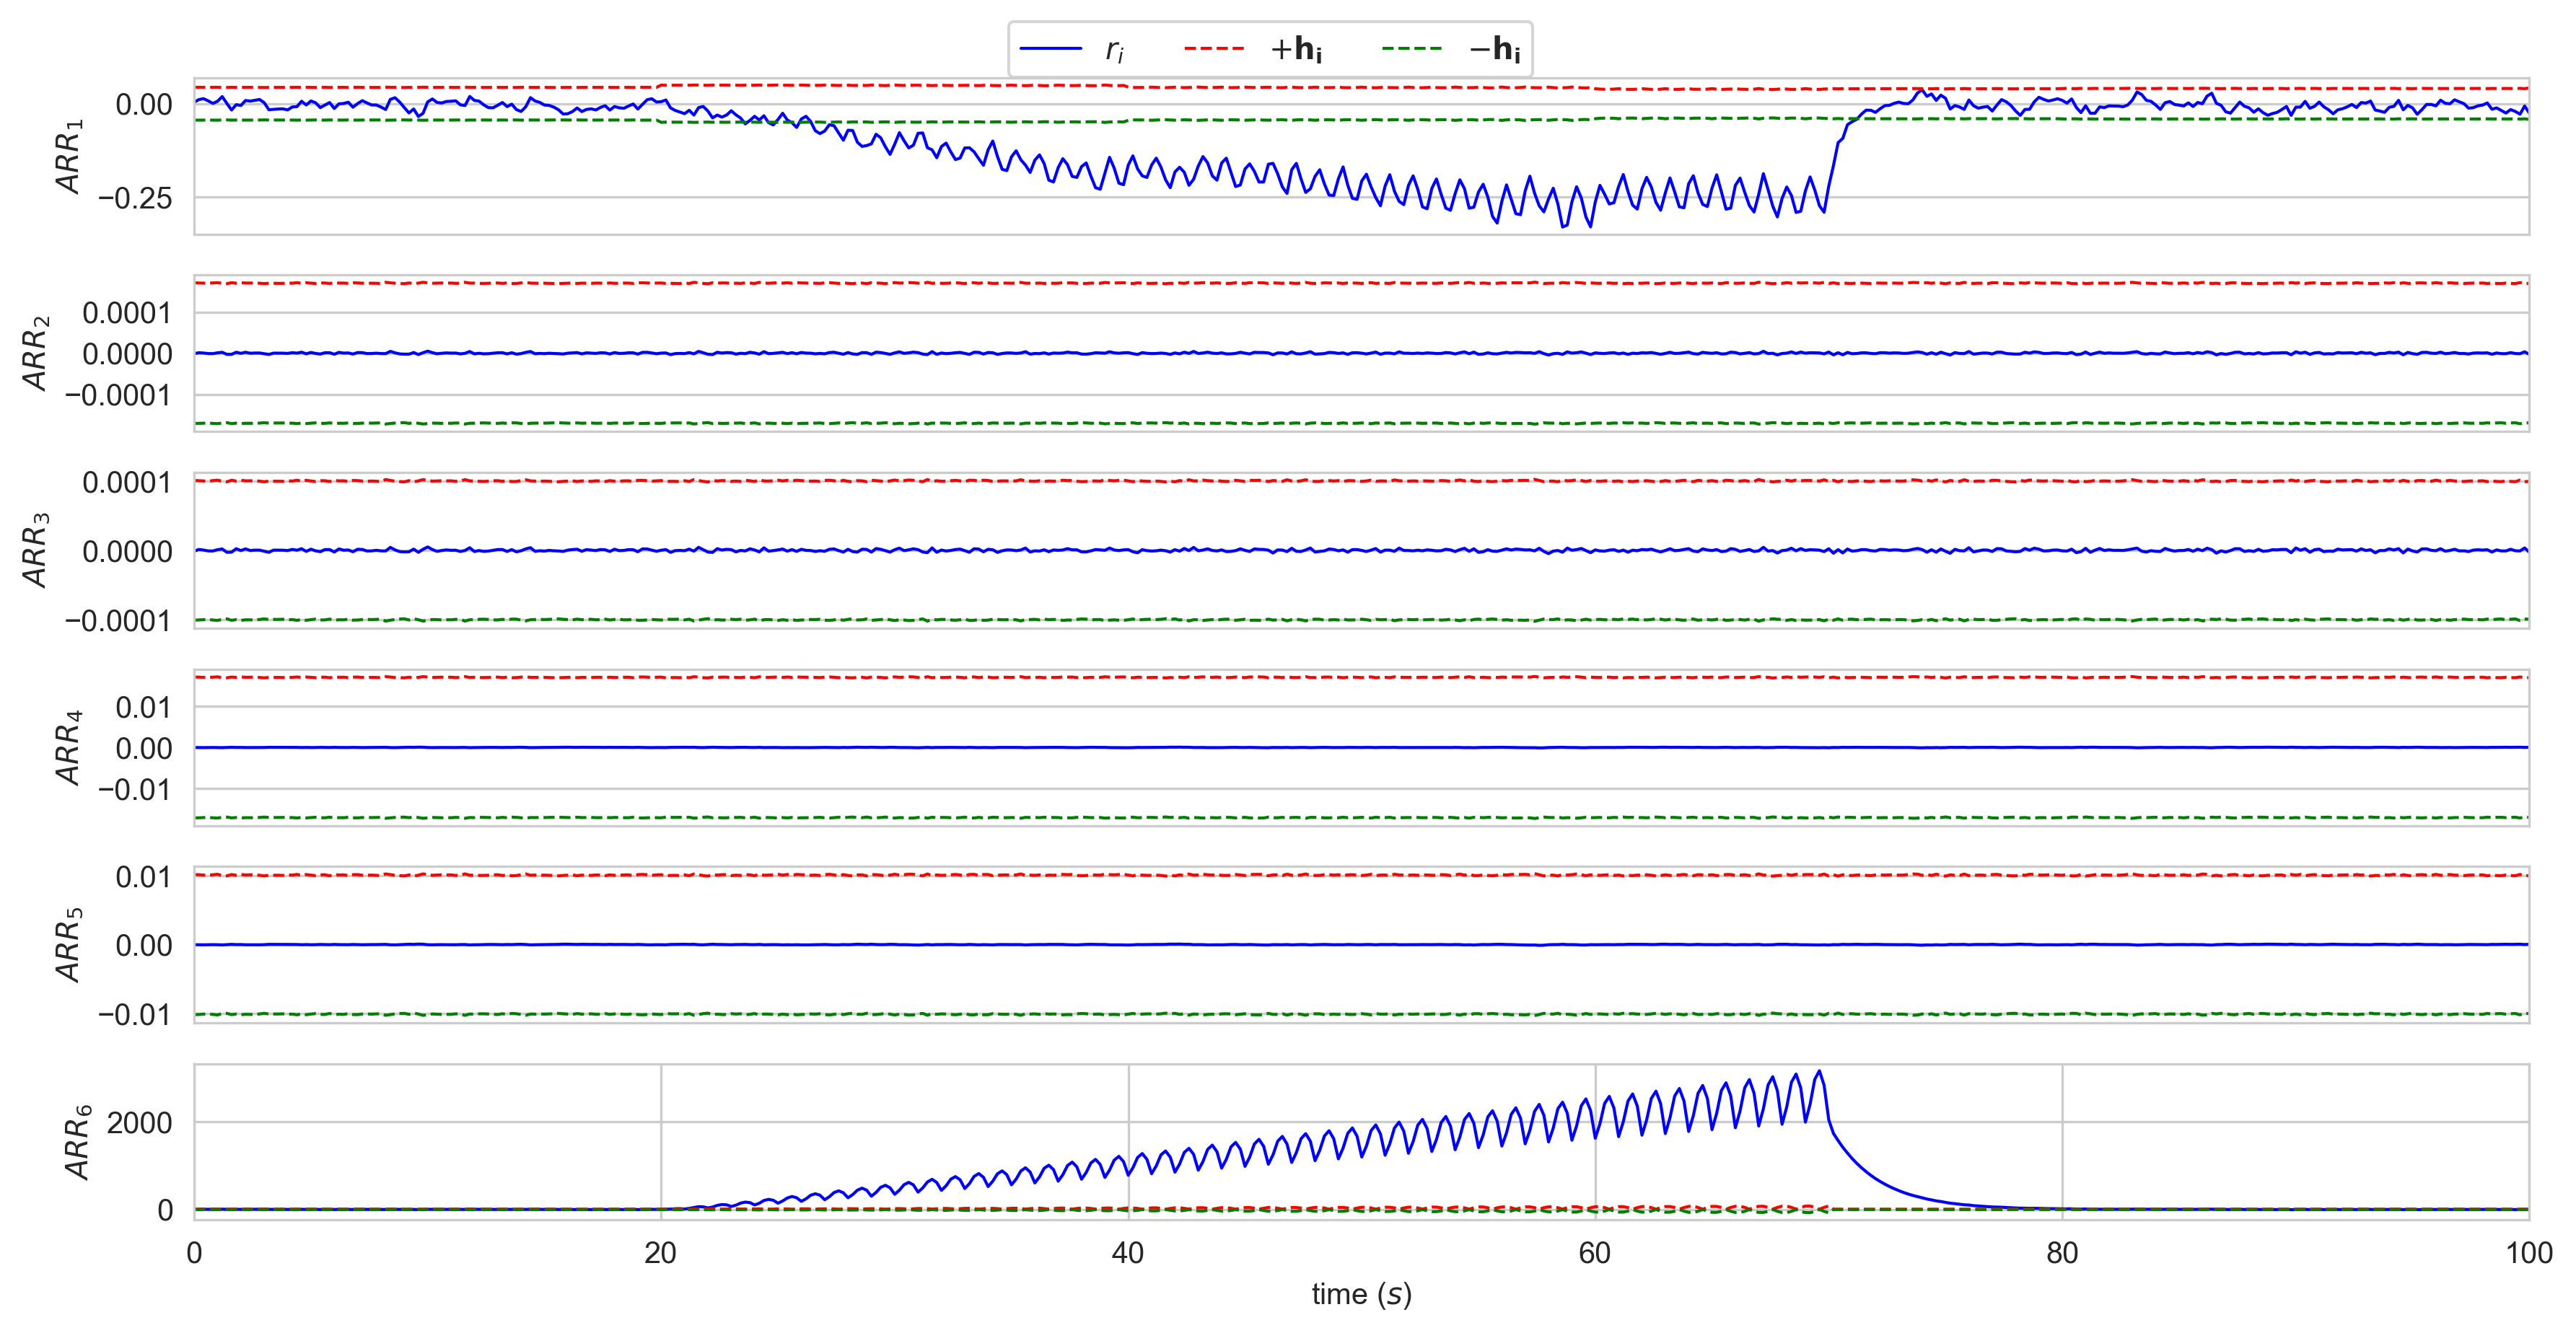

In [7]:
import matplotlib.pyplot as plt
import numpy as np


arr_df = pd.read_csv('ARR_threshold.csv')
Tst_fault_df = arr_df[(arr_df['time'] >= 880) & (arr_df['time'] <= 980)]

time_axis = np.linspace(0,100,len(Rdiff_fault_df))


sns.set_style("whitegrid")

# Define the array of plots
fig, axs = plt.subplots(6, 1, figsize=(12, 6),dpi=300)

# Loop over the plots and plot the data
for i, ax in enumerate(axs.flat):
    ax.plot(time_axis, Tst_fault_df  [f"ARR{i+1}"], label='$r_{i}$', color='b', linewidth=1)
    ax.plot(time_axis, Tst_fault_df  [f"h{i+1}"], label='$+ \mathbf{h_{i}}$', color='red', linewidth=1,linestyle='--',alpha=1)
    ax.plot(time_axis, Tst_fault_df  [f"h{i+1}"] * -1, label='$- \mathbf{h_{i}}$', color='green', linewidth=1,linestyle='--',alpha=1)
    # if i+1 == 3:
        # ax.set_ylim([-0.0008,0.0008])

    # elif i+1 ==6:
        # ax.set_ylim([-90,90])

    ax.set_xlim([0,100])

    if i + 1 < 6:
        ax.set_xticks([])  # Hide x-ticks for all subplots except the last one
        


    # ax.set_ylim([arr_df[f"ARR{i+1}"].min(), arr_df[f"ARR{i+1}"].max()])
    ax.set_ylabel(f'$ARR_{i+1}$')#ax.set_title(f'$ARR_{i+1}$')
ax.set_xlabel('time ($s$)')
# Add horizontal spacing between subplots
# plt.subplots_adjust(hspace=1)
# plt.subplots_adjust(wspace=0.4)
# Add a common legend
handles, labels = axs[-1].get_legend_handles_labels()
fig.legend(handles, labels, bbox_to_anchor=(0.6, 1.03), ncol=3,markerscale=1.5,fontsize=10)
plt.tight_layout()

# Increase DPI and save the figure
fig.savefig('Plots/Tst_fault_arr_plot.pdf', dpi=300,bbox_inches='tight')
# Display the plots
plt.show()

# LFT-FSM based FDI

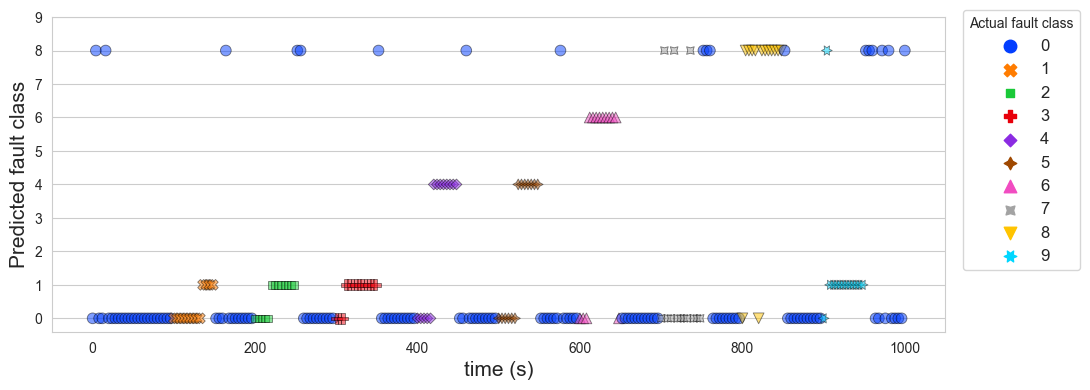

In [8]:
df = pd.read_csv('LFT_FSM_Result.csv')

df = df.iloc[::20]

sns.set_style("whitegrid")
# plt.style.use('fivethirtyeight')
# Plot the line plot
plt.subplots(figsize=(11,4))

sns.scatterplot(x=df.time,y=df.fault_pred,hue=df.Fault_class,style=df.Fault_class,palette="bright",edgecolor='black',alpha=0.5,s=60)
# Add labels and title
plt.xlabel('time (s)',fontsize=15)
plt.ylabel('Predicted fault class',fontsize=15)

plt.yticks([0,1,2,3,4,5,6,7,8,9])
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
plt.legend(markerscale=1.5,bbox_to_anchor=(1.01, 1.05),title='Actual fault class',fontsize=12)
plt.grid(axis='x')
plt.tight_layout()

# Increase DPI and save the figure
plt.savefig('Plots/lft_fsm_result.pdf', dpi=300)
# Display the plot
plt.show()

# SSL + RF visualization

In [9]:
df

,time,ARR1,ARR2,ARR3,ARR4,ARR5,ARR6,C1,C2,C3,C4,C5,C6,Fault_class,fault_pred
0,0.0,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0,0,0,0,0,0,0,0
20,4.0,-0.013132,-1.372949e-06,-1.187867e-06,2.910222e-05,2.910222e-05,5.176897,0,0,0,0,0,1,0,8
40,8.0,0.003686,1.502649e-06,1.457916e-06,-8.502743e-06,-8.502743e-06,2.194014,0,0,0,0,0,0,0,0
60,12.0,0.006140,7.486705e-07,6.696821e-07,-1.398859e-05,-1.398859e-05,0.313218,0,0,0,0,0,0,0,0
80,16.0,0.023860,1.496391e-07,-1.660258e-07,-5.439146e-05,-5.439146e-05,3.975463,0,0,0,0,0,1,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4920,984.0,0.000313,-4.595110e-07,-4.662341e-07,-9.565950e-07,-9.565950e-07,0.105791,0,0,0,0,0,0,0,0
4940,988.0,0.007190,-1.599785e-06,-1.702632e-06,-1.684470e-05,-1.684470e-05,1.871340,0,0,0,0,0,0,0,0
4960,992.0,0.013068,1.934401e-06,1.762401e-06,-3.062235e-05,-3.062235e-05,3.762644,0,0,0,0,0,0,0,0
4980,996.0,0.004577,1.086897e-06,1.027756e-06,-1.075351e-05,-1.075351e-05,0.583000,0,0,0,0,0,0,0,0


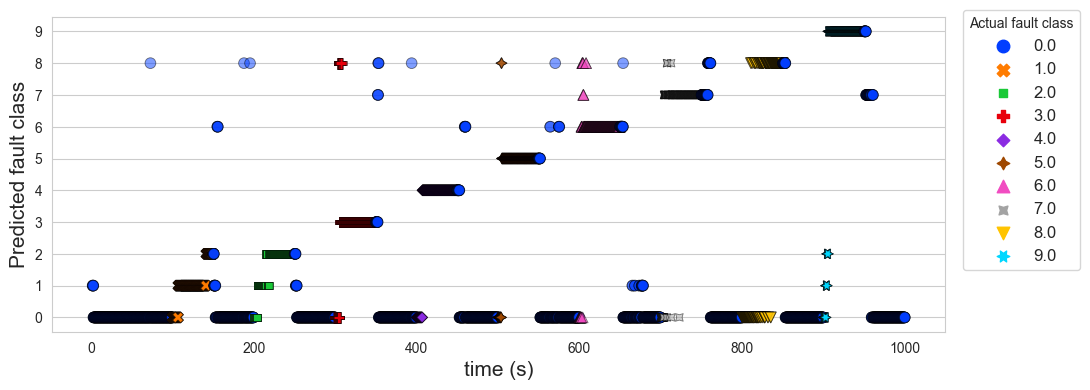

In [10]:
df = pd.read_csv('SSL_FineTuned_Results.csv')

# df = df.iloc[::20]

# sns.set_style("whitegrid")
# Plot the line plot
plt.subplots(figsize=(11,4))

sns.scatterplot(x=df.time,y=df['predicted class'],hue=df['actual class'],style=df['actual class'],palette="bright",edgecolor='black',alpha=0.5,s=60)

# Add labels and title
plt.xlabel('time (s)',fontsize=15)
plt.ylabel('Predicted fault class',fontsize=15)

plt.yticks([0,1,2,3,4,5,6,7,8,9])
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
plt.legend(markerscale=1.5,bbox_to_anchor=(1.01, 1.05),title='Actual fault class',fontsize=12)
plt.grid(axis='x')
plt.tight_layout()
# Increase DPI and save the figure
plt.savefig('Plots/ssl_finetuned_result.pdf', dpi=300)
# Display the plot
plt.show()

# The PCA Visualization

## Raw data

In [11]:
data =  pd.read_csv('Electrolyzer_faults.csv')
X,Y,Z = sliding_window(data, window_size=10, stride=1)

from sklearn.preprocessing import StandardScaler
sc= StandardScaler()
X_sc=sc.fit_transform(X.reshape(-1,X.shape[2])).reshape(X.shape)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

x_before_training,y_before_training,z_before_training = resample(X_sc,Y,Z,50)

from sklearn.manifold import TSNE
t_sne = TSNE(n_components=2,perplexity=20)

x_before_training = t_sne.fit_transform(x_before_training.reshape(len(x_before_training),-1))




c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## SSL embeddings

In [12]:
# Split data ito train and test
x_train, x_test, z_train, z_test = train_test_split(X_sc, Z, test_size=0.3)
# Pretraining of the DL model using psuedo labels
dl_model = DeepLearningModel(x_train, z_train,last_layer_activn='sigmoid',loss_fn='binary_crossentropy')
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = dl_model.fit(x_train, z_train, epochs=200, batch_size=256, validation_data=(x_test, z_test), callbacks=[early_stop],verbose=0)

#Get the embedding Layer
intermediate_model = Model(inputs=dl_model.input,outputs=dl_model.layers[-3].output)
# Convert all X_sc into X_emd
x_pre_training,y_pre_training,_ = resample(X_sc,Y,Z,50)
x_pre_training = intermediate_model.predict(x_pre_training)

# Converting to 2d for visualization
x_pre_training = t_sne.fit_transform(x_pre_training)


c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### Pretraining Loss plot

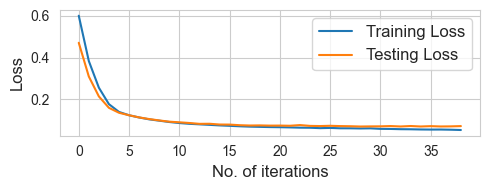

In [13]:
sns.set_style("whitegrid")
# Plot the line plot
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Testing Loss')
ax.set_xlabel('No. of iterations',fontsize=12)
ax.set_ylabel('Loss',fontsize=12)
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
ax.legend(markerscale=1.5,loc='upper right',fontsize=12)
# ax.set_ylim([0.4,1.01])

plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/pretrainingLossVsepoch.pdf', dpi=300)
# Display the plot
plt.show()

## Fine Tuned Model

In [14]:
# OHE of target
samples = 32

ohe = OneHotEncoder(sparse=False)
Y_ohe = ohe.fit_transform(Y.reshape(-1,1))

x_train,y_train,_ = resample(X_sc,Y,Z,samples)
y_train = ohe.transform(y_train.reshape(-1,1))

fine_tuned_model,history1,history2 = FineTunedModel(dl_model,x_train,y_train,X_sc,Y_ohe)
# get the intermediate layer outpur (embeddings)
intermediate_finetuned_model = Model(inputs=fine_tuned_model.input,outputs=fine_tuned_model.layers[-2].output)
# Convert all X_sc into X_emd
x_fine_tuning,y_fine_tuning,_ = resample(X_sc,Y,Z,50)
x_fine_tuning = intermediate_finetuned_model.predict(x_fine_tuning)

# Converting to 2d for visualization
x_fine_tuning = t_sne.fit_transform(x_fine_tuning)


c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\Administrator\miniconda3\envs\tensorflow\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### Fine tuning loss

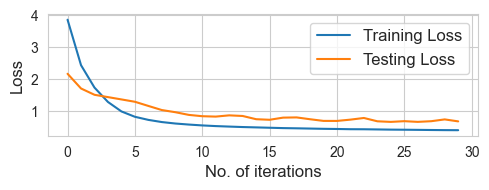

In [15]:
sns.set_style("whitegrid")
# Plot the line plot
fig, ax = plt.subplots(figsize=(5,2))
ax.plot(history1.history['loss'], label='Training Loss')
ax.plot(history1.history['val_loss'], label='Testing Loss')
ax.set_xlabel('No. of iterations',fontsize=12)
ax.set_ylabel('Loss',fontsize=12)
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
ax.legend(markerscale=1.5,loc='upper right',fontsize=12)
# ax.set_ylim([0.4,1.01])

plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/FinetuningLossVsepoch.pdf', dpi=300)
# Display the plot
plt.show()

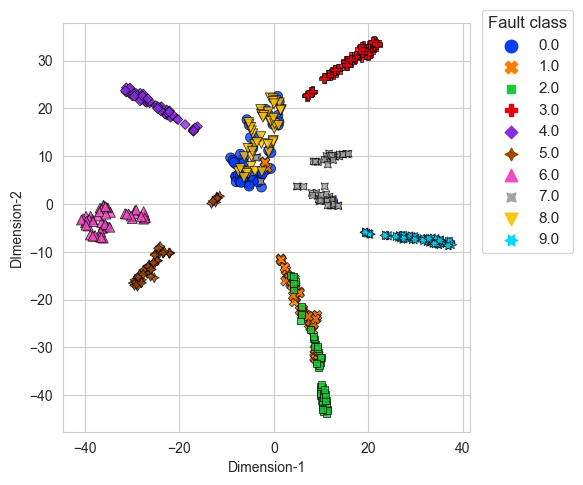

In [16]:
# plt.style.use('fivethirtyeight')
# Plot the line plot
# fig, [ax1,ax2,ax3 ]= plt.subplots(1,3,figsize=(12,4))
fig, ax3 = plt.subplots(figsize=(6,5))

ds = 3

sns.set(style="whitegrid", palette="colorblind")

# sns.scatterplot(x=x_before_training[:,0],y=x_before_training[:,1],hue=y_before_training[:],style=y_before_training[:],palette="bright",edgecolor='black',alpha=0.3,ax=ax1,legend=False,s=50)
# sns.scatterplot(x=x_pre_training[:,0],y=x_pre_training[:,1],hue=y_pre_training[:],style=y_pre_training[:],palette="bright",edgecolor='black',alpha=0.3,ax=ax2,legend=False,s=50)
sns.scatterplot(x=x_fine_tuning[:,0],y=x_fine_tuning[:,1],hue=y_fine_tuning[:],style=y_fine_tuning[:],palette="bright",edgecolor='black',alpha=0.8,ax=ax3,s=50)

# # Add labels and title
# ax1.set_xlabel('PC-1')
# ax1.set_ylabel('PC-2')
# ax1.set_title('Before SSL')

# ax2.set_xlabel('PC-1')
# ax2.set_ylabel('PC-2')
# ax2.set_title('After pretraining')


ax3.set_xlabel('Dimension-1')
ax3.set_ylabel('DImension-2')
# ax3.set_title('After fine tuning')
ax3.legend(markerscale=1.5,bbox_to_anchor=(1.01, 1.05),title='Fault class')

plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/two_dim_visualization.pdf', dpi=300)
# Display the plot
plt.show()

# Just the Hybrid approach

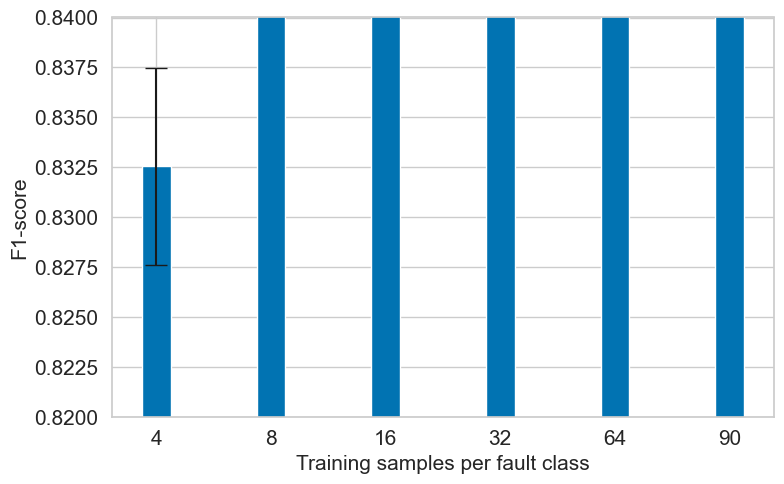

In [17]:
df = pd.read_csv('experiment_results.csv')
# Plot the line plot
sns.set(style="whitegrid", palette="colorblind")

fig, ax = plt.subplots(figsize=(8,5))


set_of_samples = df['No training samples'].unique()
bar_width = 0.25
index = np.arange(len(set_of_samples))

plt.bar(index , df[df['Model']=='residual + SSL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='residual + SSL']['Error'], capsize=8)
# plt.bar(index - 0.5 * bar_width, df[df['Model']=='residual + SL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='residual + SL']['Error'], capsize=5, label='residual + SL')
# plt.bar(index + 0.5 * bar_width, df[df['Model']=='sensor + SSL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='sensor + SSL']['Error'], capsize=5, label='sensor + SSL')
# plt.bar(index + 1.5 * bar_width, df[df['Model']=='sensor + SL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='sensor + SL']['Error'], capsize=5, label='sensor + SL')

plt.xlabel('Training samples per fault class',fontsize=15)
plt.ylabel('F1-score',fontsize=15)
# plt.title('Comparison of Different Models for Varying Window Lengths')
plt.xticks(index, [str(w) for w in set_of_samples])

# Increase the font size of x and y ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Increase the legend font size
# legend = plt.legend(loc='lower right')
# for item in legend.get_texts():
#     item.set_fontsize(15)
plt.grid(visible=True)

plt.ylim(0.82,0.84)
plt.tight_layout()
# Increase DPI and save the figure
# fig.savefig('Plots/Hybrid_method_F1_dataSamples.pdf', dpi=300)
# Display the plot
plt.show()

# Plot the confusion matrix

In [27]:
def Cascade_Hybrid_FDI(Z,y_pred):
    Cascade_hybrid_prediction=np.zeros(len(y_pred))

    for i,fs in enumerate(Z):
        if sum(fs)>0:
            Cascade_hybrid_prediction[i]=y_pred[i]

    return Cascade_hybrid_prediction

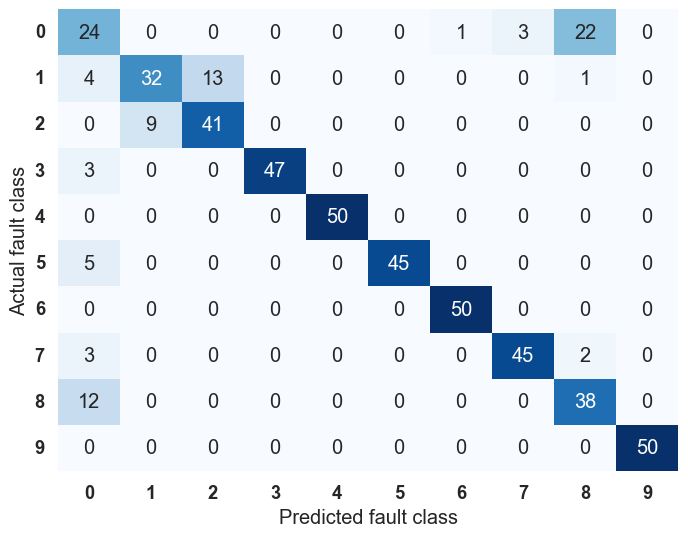

In [29]:
# 50 samples is used as 20% of validation data
from sklearn.metrics import confusion_matrix

x_fine_tuning,y_fine_tuning,z_resampled = resample(X_sc, Y, Z, 50)
y_pred_fn = fine_tuned_model.predict(x_fine_tuning)
y_pred_fn = ohe.inverse_transform(y_pred_fn)
y_pred_fn = Cascade_Hybrid_FDI(z_resampled,y_pred_fn)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_fine_tuning, y_pred_fn, labels=ohe.categories_[0])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.set(font_scale=1.2)  # Adjust the font size as needed

fault_labels = [str(int(x)) for x in ohe.categories_[0]]
ax = sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=fault_labels, yticklabels=fault_labels)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0, weight='bold') 
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, weight='bold') 
plt.xlabel("Predicted fault class")
plt.ylabel("Actual fault class")
# plt.title("Confusion Matrix")
plt.savefig('Plots/confusion_matrix_50_samples.pdf', dpi=300)
# Show the plot
plt.show()

# Effect of the size of window length

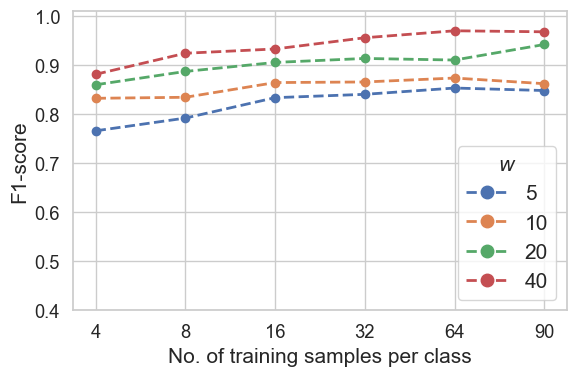

In [22]:
df = pd.read_csv('Effect_of_window_length.csv')

sns.set_style("whitegrid")
# Plot the line plot
fig, ax = plt.subplots(figsize=(6,4))

for row in range(len(df)):
    ax.plot(df.iloc[row,1:], label=str(df.iloc[row,0]), marker='o',linestyle='--',linewidth=2)

# Add labels and title
ax.set_xlabel('No. of training samples per class',fontsize=15)
ax.set_ylabel('F1-score',fontsize=15)
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
ax.legend(markerscale=1.5,loc='lower right',title='$w$',fontsize=15)
ax.set_ylim([0.4,1.01])

plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/effect_of_window_length.pdf', dpi=300)
# Display the plot
plt.show()

# Effect of the type of DL algorithm

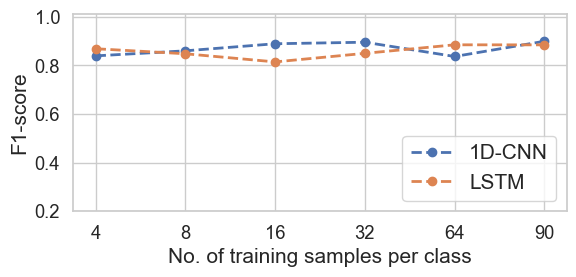

In [23]:
df = pd.read_csv('Effect_of_DL_model.csv')

sns.set_style("whitegrid")
# Plot the line plot
fig, ax = plt.subplots(figsize=(6,3))

for row in range(len(df)):
    ax.plot(df.iloc[row,1:], label=str(df.iloc[row,0]), marker='o',linestyle='--',linewidth=2)

# Add labels and title
ax.set_xlabel('No. of training samples per class',fontsize=15)
ax.set_ylabel('F1-score',fontsize=15)
# ax.set_title('Line Plot of Dataset Size vs. Win Length')
ax.legend(loc='lower right',fontsize=15)
ax.set_ylim([0.2,1.01])
plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/effect_of_DL_algo.pdf', dpi=300)
# Display the plot
plt.show()

# Effect of raw_sensor data, raw_sensor + SSL, residuals, residuals+SSL     (LSTM,win_length=40)

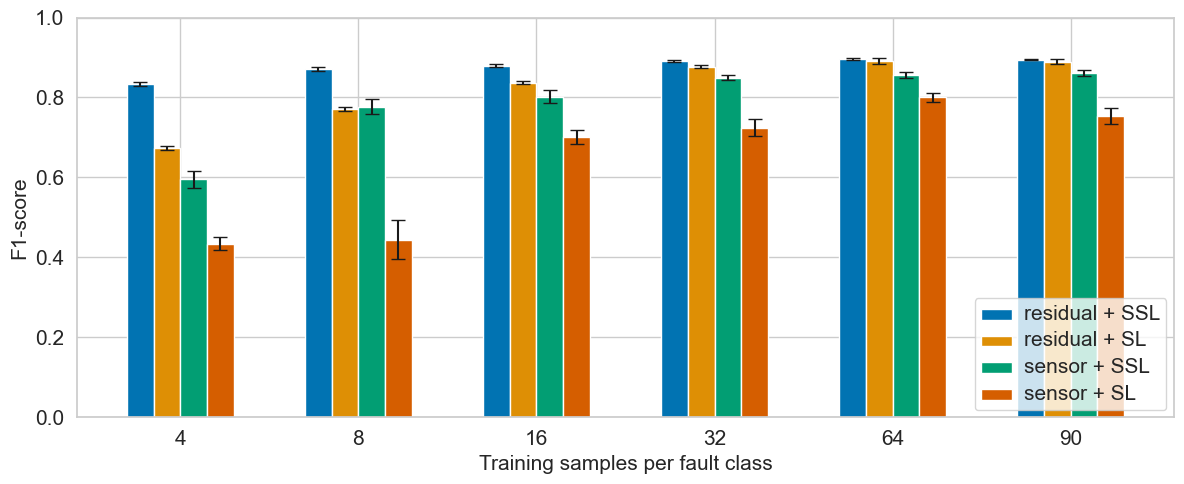

In [24]:
df = pd.read_csv('experiment_results.csv')
# Plot the line plot
sns.set(style="whitegrid", palette="colorblind")

fig, ax = plt.subplots(figsize=(12,5))


set_of_samples = df['No training samples'].unique()
bar_width = 0.15
index = np.arange(len(set_of_samples))

plt.bar(index - 1.5 * bar_width, df[df['Model']=='residual + SSL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='residual + SSL']['Error'], capsize=5, label='residual + SSL')
plt.bar(index - 0.5 * bar_width, df[df['Model']=='residual + SL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='residual + SL']['Error'], capsize=5, label='residual + SL')
plt.bar(index + 0.5 * bar_width, df[df['Model']=='sensor + SSL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='sensor + SSL']['Error'], capsize=5, label='sensor + SSL')
plt.bar(index + 1.5 * bar_width, df[df['Model']=='sensor + SL']['Mean F1 score'], bar_width, yerr=df[df['Model']=='sensor + SL']['Error'], capsize=5, label='sensor + SL')

plt.xlabel('Training samples per fault class',fontsize=15)
plt.ylabel('F1-score',fontsize=15)
# plt.title('Comparison of Different Models for Varying Window Lengths')
plt.xticks(index, [str(w) for w in set_of_samples])

# Increase the font size of x and y ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Increase the legend font size
legend = plt.legend(loc='lower right')
for item in legend.get_texts():
    item.set_fontsize(15)
plt.grid(visible=True)

plt.ylim([0,1])
plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/effect_of_dataType.pdf', dpi=300)
# Display the plot
plt.show()

# State of the ART comparision

In [25]:
df = pd.read_csv('experiment_results.csv') #import all the rsultd from supervised and pore ssl

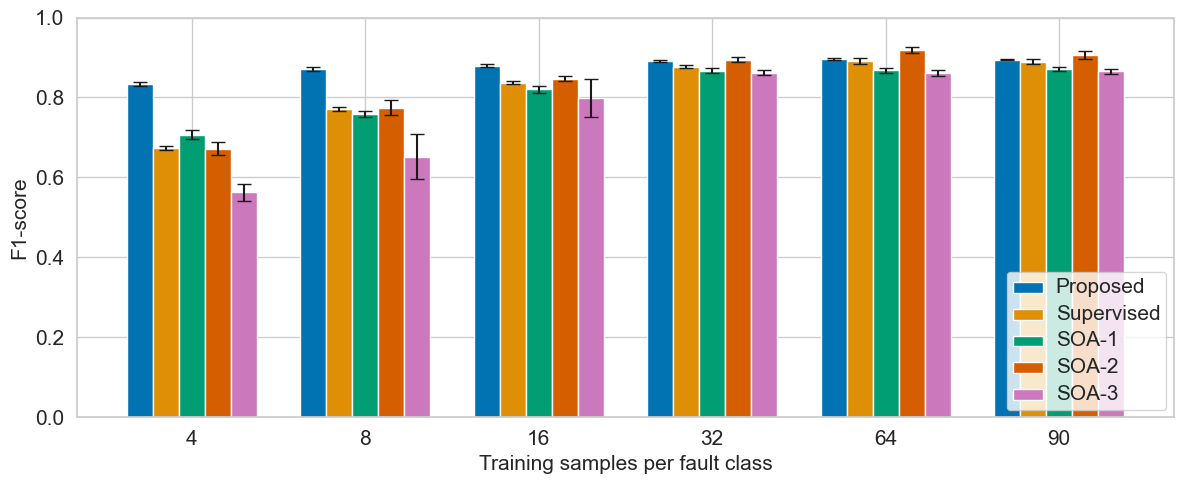

In [26]:
soa1=pd.read_csv("SOA1_DAE.csv")
soa2=pd.read_csv("SOA2_mask_pred.csv")
soa3=pd.read_csv("SOA3_siamese.csv")

hybrid = df[df['Model']=='residual + SSL']
supervised = df[df['Model']=='residual + SL']


# Plot the line plot
sns.set(style="whitegrid", palette="colorblind")

fig, ax = plt.subplots(figsize=(12,5))


set_of_samples = df['No training samples'].unique()
bar_width = 0.15
index = np.arange(len(set_of_samples))

plt.bar(index - 2 * bar_width, hybrid['Mean F1 score'], bar_width, yerr=hybrid['Error'], capsize=5, label='Proposed')
plt.bar(index - 1 * bar_width, supervised['Mean F1 score'], bar_width, yerr=supervised['Error'], capsize=5, label='Supervised')
plt.bar(index , soa1['Mean F1 score'], bar_width, yerr=np.sqrt(soa1['Error']), capsize=5, label='SOA-1')
plt.bar(index + 1* bar_width, soa2['Mean F1 score'], bar_width, yerr=np.sqrt(soa2['Error']), capsize=5, label='SOA-2')
plt.bar(index + 2 * bar_width, soa3['Mean F1 score'], bar_width, yerr=np.sqrt(soa3['Error']), capsize=5, label='SOA-3')

plt.xlabel('Training samples per fault class',fontsize=15)
plt.ylabel('F1-score',fontsize=15)
# plt.title('Comparison of Different Models for Varying Window Lengths')
plt.xticks(index, [str(w) for w in set_of_samples])

# Increase the font size of x and y ticks
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Increase the legend font size
legend = plt.legend(loc='lower right')
for item in legend.get_texts():
    item.set_fontsize(15)
plt.grid(visible=True)
plt.ylim([0,1])

plt.tight_layout()
# Increase DPI and save the figure
fig.savefig('Plots/SOAT_comparision.pdf', dpi=300)
# Display the plot
plt.show()